In [11]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [12]:
import numpy as np
import pandas as pd

In [13]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [17]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [18]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [19]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [21]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [22]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [23]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [30]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Get the last date in the measurement table
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date


('2017-08-23')

In [271]:
# Calculate the date 1 year ago from the last data point in the database
date_oneyear_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(date_oneyear_ago)                                                      

2016-08-23


In [272]:
# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= date_oneyear_ago).\
    order_by(Measurement.date).all()


In [273]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_query_df = pd.DataFrame(query, columns=['Date','Precipitation'])
prcp_query_df.set_index('Date', inplace=True)
prcp_query_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


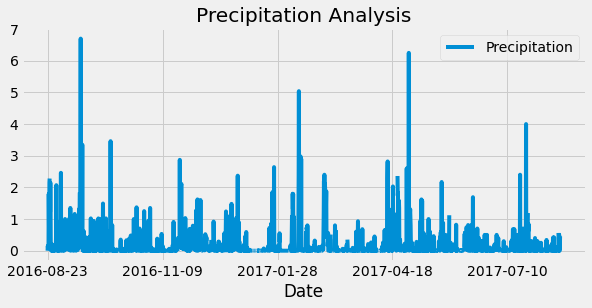

In [55]:
# Use Pandas Plotting with Matplotlib to plot the data
query_df.plot(title="Precipitation Analysis", figsize=(9,4)
plt.legend(loc='upper right')
plt.show()


In [56]:
# Use Pandas to calcualte the summary statistics for the precipitation data
query_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [57]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).distinct().count()
station_count

9

In [60]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [70]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()

highest_temp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()

average_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()

print (lowest_temp, highest_temp, average_temp)

[(54.0,)] [(85.0,)] [(71.66378066378067,)]


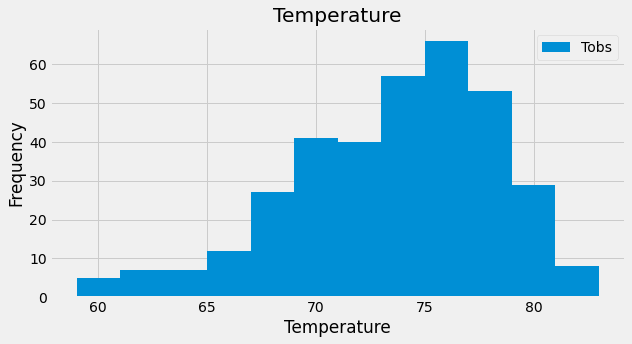

In [83]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
observation_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= date_oneyear_ago).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date).all()

observation_data_df = pd.DataFrame(observation_data, columns=['Date','Tobs'])

observation_data_df.plot.hist(bins=12, title="Temperature", figsize=(9,5))
plt.xlabel("Temperature")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


## Bonus Challenge Assignment

In [85]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [103]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp_mytrip = calc_temps('2017-05-14', '2017-05-28')
temp_mytrip

[(68.0, 74.88235294117646, 87.0)]

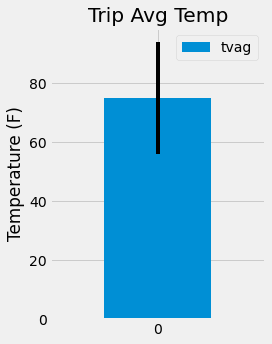

In [131]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temp_mytrip_df = pd.DataFrame(temp_mytrip, columns =['tmin','tvag','tmax'])
peak_to_peak = temp_mytrip_df['tmax'] - temp_mytrip_df['tmin']
temp_mytrip_df.plot.bar( y='tvag', rot=0, title='Trip Avg Temp', yerr=peak_to_peak, figsize=(4,5))
plt.ylabel('Temperature (F)')
plt.tight_layout()
plt.show()

In [170]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_rainfall = session.query(Measurement.station, func.sum(Measurement.prcp)).\
    group_by(Measurement.station).all()
    
total_rainfall_df = pd.DataFrame(total_rainfall, columns=['station','rainfall'])
station_query = session.query(Station.station, Station.name,Station.latitude,Station.longitude, Station.elevation)
station_df = pd.DataFrame(station_query, columns=['station','name','latitude','longitude','elevation'])
combined = pd.merge(station_df, total_rainfall_df, on='station', how='inner')
combined.sort_values(by=['rainfall'], ascending=False)

,station,name,latitude,longitude,elevation,rainfall
8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1068.09
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,588.64
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,382.62
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,295.68
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,234.49
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,131.62
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,92.68
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,70.87
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,43.44


In [171]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [270]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.date(2017,5,14)

# Use the start and end date to create a range of dates
day_series = pd.Series(pd.date_range(start_date, periods=15, freq="d"))

# Stip off the year and save a list of %m-%d strings
trip_days = day_series.dt.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for day in trip_days:
    normals.append(daily_normals(day))
    
normals

[[(63.0, 73.89285714285714, 80.0)],
 [(63.0, 73.69090909090909, 79.0)],
 [(68.0, 74.37931034482759, 80.0)],
 [(68.0, 74.45, 79.0)],
 [(68.0, 74.10714285714286, 82.0)],
 [(65.0, 73.80701754385964, 79.0)],
 [(68.0, 73.89655172413794, 79.0)],
 [(64.0, 72.96428571428571, 80.0)],
 [(64.0, 74.45614035087719, 80.0)],
 [(68.0, 74.94827586206897, 87.0)],
 [(67.0, 73.94827586206897, 79.0)],
 [(68.0, 74.27586206896552, 79.0)],
 [(65.0, 74.03636363636363, 82.0)],
 [(65.0, 74.49090909090908, 80.0)],
 [(67.0, 74.27777777777777, 82.0)]]

In [265]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
